In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai import *
from fastai.vision import *
from fastai.callbacks.hooks import *

In [3]:
from scipy.io import loadmat                                                                         
from scipy.misc import imsave
import urllib.request

In [4]:
torch.backends.cudnn.benchmark=True

## Read Mat files and convert and save them to png 

In [5]:
PATH = Path('./portseg_data')
masks = 'data/images_mask'
images = 'data/images_tracker'

In [6]:
mask_files = list((PATH/masks).iterdir())

In [7]:
mask = loadmat(mask_files[0])['mask']

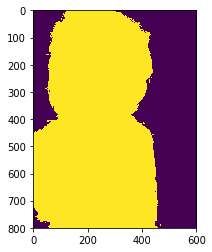

In [8]:
plt.imshow(mask*255)

In [10]:
def img_summary(im):
    print ("shape: {}, dtype: {}, min: {}, max: {}, mean: {}, std: {}".format(
        im.shape, im.dtype, im.min(), im.max(), im.mean(), im.std()))

In [10]:
img_summary(mask)

shape: (800, 600), dtype: uint8, min: 0, max: 1, mean: 0.6388354166666667, std: 0.48033813827239763


In [11]:
im_files = list((PATH/images).iterdir())

In [193]:
str(PATH/'data/masks_png')

'portseg_data/data/masks_png'

In [382]:
(PATH/'data/masks_png').mkdir(exist_ok=True)

def convert_mat2png(fn):
    mask = loadmat(fn)['mask']
    fn = fn.name
    PIL.Image.fromarray(np.uint8(mask)).save(PATH/'data/masks_png'/f'{fn[:-9]}.png')

im_files = list((PATH/'data/images_mask').iterdir())

In [383]:
convert_mat2png(im_files[0])

In [384]:
with ThreadPoolExecutor(8) as e: e.map(convert_mat2png, im_files)

In [385]:
mask_files = list((PATH/'data/masks_png').iterdir())

In [386]:
mask_files[0].name

'02422.png'

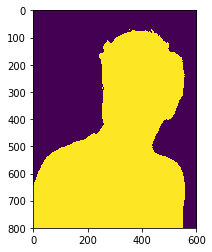

In [387]:
mask = Image.open(mask_files[140])

mask_array = np.array(mask)

plt.imshow(mask_array); plt.show()

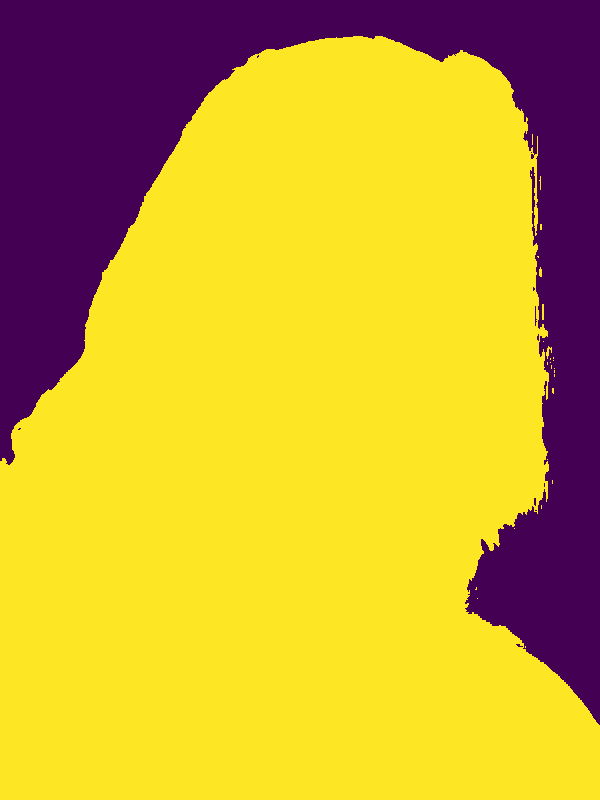

In [388]:
open_mask(mask_files[0])

## Tracker

In [13]:
im = loadmat(im_files[0])['tracker']

In [14]:
img_summary(im)

shape: (49, 2), dtype: float32, min: 137.88426208496094, max: 534.955078125, mean: 337.021484375, std: 105.79956817626953


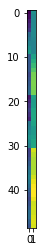

In [15]:
plt.imshow(im)

## Download data from flickr

In [84]:
imgs_names = np.loadtxt(PATH/'data/alldata_urls.txt', dtype=np.str)

In [85]:
ls_imgs = list(imgs_names)

In [86]:
(PATH/'data/flickr_images').mkdir(exist_ok=True)

In [87]:
def download_flickr(fn):
#     if 'None' not in fn[1]:
    urllib.request.urlretrieve(fn[1], PATH/'data/flickr_images'/fn[0])   

In [88]:
with ThreadPoolExecutor(8) as e: e.map(download_flickr, ls_imgs)

In [20]:
download_flickr(ls_imgs[2])

In [161]:
im_files = sorted(list((PATH/'data/flickr_images').iterdir()))

In [162]:
len(im_files)

1768

## Convert images to png

In [98]:
crop_params = np.loadtxt(PATH/'data/crop.txt', dtype=np.str)

In [106]:
crop_params_ls = list(crop_params)

In [102]:
(PATH/'data/flickr_images_png')

PosixPath('portseg_data/data/flickr_images_png')

In [153]:
(PATH/'data/flickr_images_png').mkdir(exist_ok=True)

def convert_img2png(fn):
    area = (int(fn[3]), int(fn[1]), int(fn[4]), int(fn[2]))
    img = PIL.Image.open(PATH/'data/flickr_images'/fn[0]).crop(area).resize((600, 800))
    img.save(PATH/'data/flickr_images_png'/f'{fn[0][:-4]}.png')

# im_files = list((PATH/'data/flickr_images').iterdir())

In [154]:
with ThreadPoolExecutor(8) as e: e.map(convert_img2png, crop_params_ls)

In [169]:
img_files = sorted(list((PATH/'data/flickr_images_png').iterdir()))

In [170]:
len(img_files)

1759

In [329]:
im = np.array(PIL.Image.open(img_files[0]))

In [330]:
img_summary(im)

shape: (800, 600, 3), dtype: uint8, min: 0, max: 255, mean: 95.32926388888889, std: 52.65449240106389


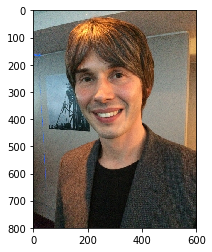

In [331]:
plt.imshow(im)

In [333]:
PIL.Image.open(img_files[0]).getextrema()

((0, 255), (0, 254), (0, 255))

## Resize images and masks to 128x128 to make it easier for training

### 1. Images

In [204]:
(PATH/'data/images-128').mkdir(exist_ok=True)

def resize_img(fn):
    PIL.Image.open(fn).resize((128,128)).save((fn.parent.parent)/'images-128'/fn.name)

files = list((PATH/'data/flickr_images_png').iterdir())
# with ThreadPoolExecutor(8) as e: e.map(resize_mask, files)

In [205]:
with ThreadPoolExecutor(8) as e: e.map(resize_img, files)

### 2. Masks

In [389]:
!rm -rf ./portseg_data/data/masks-128

In [390]:
(PATH/'data/masks-128').mkdir(exist_ok=True)

def resize_img(fn):
    PIL.Image.open(fn).resize((128,128)).save((fn.parent.parent)/'masks-128'/fn.name)

files = list((PATH/'data/masks_png').iterdir())
with ThreadPoolExecutor(8) as e: e.map(resize_img, files)

### Load and see images and masks

In [6]:
images = sorted(list((PATH/'data/images-128').iterdir()))
masks = sorted(list((PATH/'data/masks-128').iterdir()))

In [7]:
masks[0]

PosixPath('portseg_data/data/masks-128/00001.png')

In [8]:
img = np.array(PIL.Image.open(images[2]))

In [11]:
img_summary(img)

shape: (128, 128, 3), dtype: uint8, min: 0, max: 255, mean: 65.2705078125, std: 67.53621763698997


In [12]:
img[...,0].mean()

85.30572509765625

In [13]:
img[...,1].mean()

58.11572265625

In [14]:
img[...,2].mean()

52.39007568359375

In [15]:
mask = np.array(PIL.Image.open(masks[0]))

In [16]:
img_summary(mask)

shape: (128, 128), dtype: uint8, min: 0, max: 1, mean: 0.5755615234375, std: 0.4942574796356694


In [17]:
np.unique(mask)

array([0, 1], dtype=uint8)

In [18]:
Path(images[0].parent.parent/'masks-128')

PosixPath('portseg_data/data/masks-128')

### Mean mask image

In [19]:
meanmask = np.array(PIL.Image.open(PATH/'data/meanmask.png'))

In [20]:
img_summary(meanmask)

shape: (800, 600), dtype: uint8, min: 3, max: 255, mean: 166.80761458333333, std: 76.58654640297334


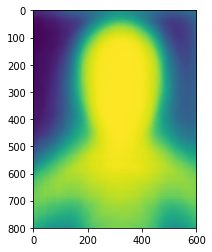

In [21]:
plt.imshow(meanmask)

In [22]:
#  img(:,:,1) = (imgcpy(:,:,3) - 104.008)/255;
#     img(:,:,2) = (imgcpy(:,:,2) - 116.669)/255;
#     img(:,:,3) = (imgcpy(:,:,1) - 122.675)/255;
portrait_stats = ([122.675/255, 116.669/255, 104.008/255], [0])

In [23]:
portrait_stats = ([0.481, 0.457, 0.407], [1.0, 1.0, 1.0])

In [24]:
MEAN_BGR = np.array([104.00698793, 116.66876762, 122.67891434])

In [25]:
imagenet_stats

([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

### Data

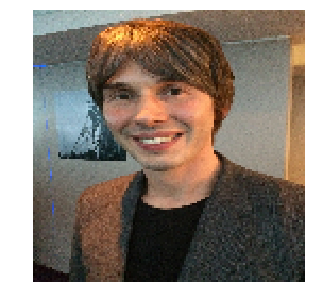

In [26]:
img_f = images[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [27]:
def get_y_fn(x): return Path(x.parent.parent/'masks-128')/x.name

codes = array(['Human', 'Background'])

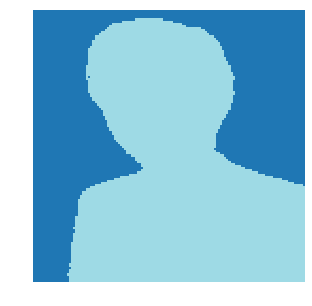

In [28]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

## Datasets

In [29]:
Path_img = PATH/'data/images-128'

In [30]:
bs, sz, wd = 8, 128, 1e-2

In [31]:
data = (SegmentationItemList.from_folder(Path_img)
       .random_split_by_pct()
       .label_from_func(get_y_fn, classes=codes)
       .transform(get_transforms(), tfm_y=True, size=sz)
       .databunch(bs = bs).normalize(portrait_stats))

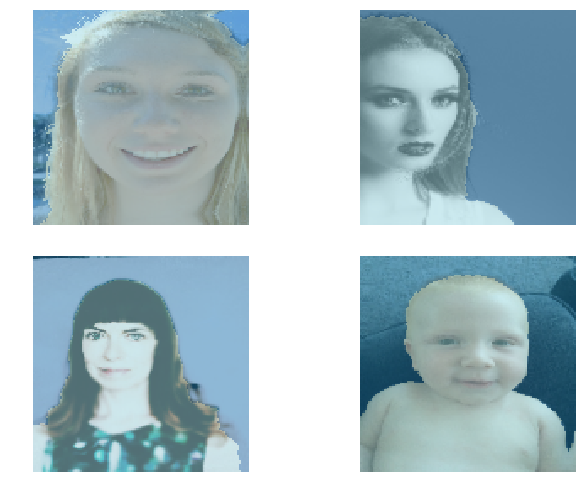

In [32]:
data.show_batch(2, figsize=(10,7))

In [33]:
data.c

2

In [34]:
data.classes

array(['Human', 'Background'], dtype='<U10')

In [35]:
x, y = next(iter(data.valid_dl))

In [36]:
x.size(), y.size()

(torch.Size([8, 3, 128, 128]), torch.Size([8, 1, 128, 128]))

In [37]:
x[3].max()

tensor(0.5930)

In [38]:
dice??

Signature: dice(input: torch.Tensor, targs: torch.Tensor, iou: bool = False) -> <function NewType.<locals>.new_type at 0x7fdf6cf5b378>
Source:   
def dice(input:Tensor, targs:Tensor, iou:bool=False)->Rank0Tensor:
    "Dice coefficient metric for binary target. If iou=True, returns iou metric, classic for segmentation problems."
    n = targs.shape[0]
    input = input.argmax(dim=1).view(n,-1)
    targs = targs.view(n,-1)
    intersect = (input * targs).sum().float()
    union = (input+targs).sum().float()
    if not iou: return (2. * intersect / union if union > 0 else union.new([1.]).squeeze())
    else: return intersect / (union-intersect+1.0)
File:      ~/anaconda3/envs/v3/lib/python3.7/site-packages/fastai/metrics.py
Type:      function


In [39]:
learn = unet_learner(data, models.resnet34, metrics=dice, wd=wd, bottle=True)

In [41]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.00E-03


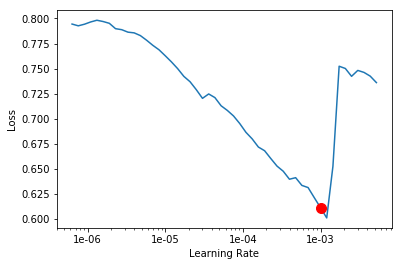

In [42]:
learn.recorder.plot()

In [43]:
lr=3e-3

In [ ]:
learn.fit_one_cycle(1, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,dice


## Dump

In [ ]:
% download data

imgs_names = textread('alldata_urls.txt','%s','delimiter','\n','whitespace','');

data_folder = 'images_data';
if ~exist(data_folder,'dir')
    mkdir(data_folder);
end

if ~exist([data_folder '_crop'],'dir')
   mkdir([data_folder '_crop']) 
end

for i=1:length(imgs_names)
    disp(['download image # ' num2str(i) ' ...']);
    try
        urlwrite(imgs_names{i}(11:end),[data_folder '/' imgs_names{i}(1:9)]);
    end
end

% crop the downloaded images
crop_parms = textread('crop.txt','%s','delimiter','\n','whitespace','');
for i=1:length(crop_parms)
    imgname = crop_parms{i}(1:9);
    crop_xy = str2num(crop_parms{i}(11:end));
    if exist([data_folder '/' imgname],'file')
        try
            img = imread([data_folder '/' imgname]);
            img = img(crop_xy(1)+1:crop_xy(2),crop_xy(3)+1:crop_xy(4),:);
            img = imresize(img,[800 600]);
            imwrite(img,[data_folder '_crop/' imgname]);
        end
    end
end

In [ ]:
def convert_img(fn):
    fn = fn.name
    Image.open(PATH/'train_masks'/fn).save(PATH/'train_masks_png'/f'{fn[:-4]}.png')

In [ ]:
from os import listdir
import os.path as osp

# from utils import get_fnames 
def get_fnames(d, random=False):
    fnames = [d + f for f in listdir(d) if osp.isfile(osp.join(d, f))]
    print("Number of files found in %s: %s" % (d, len(fnames)))
    if random:
        shuffle(fnames)
    return fnames
                                                                                                     
                                                                                                     
DATA_DIR = './portseg_data/data/portraits/flickr/cropped/'                                                       
TARGET_DIR = DATA_DIR + 'masks/targets/'                                                             
                                                                                                     
mask_fnames = get_fnames(TARGET_DIR + 'mat_files/')                                        
for fname in mask_fnames:                                                                            
    name = fname.split('/')[-1].split('.')[0][:5]                                                    
    out_path = TARGET_DIR + name + ".png"                                                            
    mask = loadmat(fname)['mask'] * 255                                                              
    imsave(out_path, mask)      

In [ ]:
(PATH/'train_masks_png').mkdir(exist_ok=True)

def convert_img(fn):
    fn = fn.name
    Image.open(PATH/'train_masks'/fn).save(PATH/'train_masks_png'/f'{fn[:-4]}.png')

files = list((PATH/'train_masks').iterdir())
with ThreadPoolExecutor(8) as e: e.map(convert_img, files)

(PATH/'train_masks-128').mkdir(exist_ok=True)

def resize_mask(fn):
    Image.open(fn).resize((128,128)).save((fn.parent.parent)/'train_masks-128'/fn.name)

files = list((PATH/'train_masks_png').iterdir())
with ThreadPoolExecutor(8) as e: e.map(resize_mask, files)

(PATH/'train-128').mkdir(exist_ok=True)

def resize_img(fn):
    Image.open(fn).resize((128,128)).save((fn.parent.parent)/'train-128'/fn.name)

files = list((PATH/'train').iterdir())
with ThreadPoolExecutor(8) as e: e.map(resize_img, files)